In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import CSVLogger, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
#import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.utils import Progbar
from tensorflow.keras.models import clone_model
from qkeras import *

# Local imports
# sys.path.insert(1, './directional-pixel-detectors/multiclassifier/')
# from hep_utils import plot_pt_filter, get_number_of_tracks, get_bkg_rej
from utils import *

2025-09-17 14:54:12.518385: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-17 14:54:12.555692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-17 14:54:12.556280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-17 14:54:23.865734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
sizes = ['50x12P5']
# Global variables
threshold = 0.2
pixel_arrayX = 16 #21 #
pixel_arrayY = 16 #13 #
noise_threshold = 0
sensor_geom = '50x12P5_100e-sigma'
dataset_name = f'dataset_2sNoise_16x16_50x12P5_100e-sigma_{noise_threshold}NoiseThresh' # for save loc of final datasets
results_dir = 'results_2sNoise_16x16_50x12P5_100e-sigma'
models_dir = 'models_2sNoise_16x16_50x12P5_100e-sigma'
thresholds = [0.2]
# store all results in this dir:
results_dir = 'model_results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
prime_num = [2,3,5,7,11,13,17,19,23,29]
for run_iter in range(1):
    for size_iter in sizes:
        for threshold in thresholds:
            tf.random.set_seed(prime_num[run_iter])
            # sensor_geom = size_iter
            print("=============================")
            # print("Run "+str(run_iter)+": Training model for ",sensor_geom," at pT boundary = ",threshold)
            df1 = pd.read_csv('./'+dataset_name+'/FullPrecisionInputTrainSet_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
            print("Shape of train dataset = ",df1.shape)
            df2 = pd.read_csv('./'+dataset_name+'/TrainSetLabel_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
            print("Shape of train-label set = ",df2.shape)
            df3 = pd.read_csv('./'+dataset_name+'/FullPrecisionInputTestSet_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
            print("Shape of test dataset = ",df3.shape)
            df4 = pd.read_csv('./'+dataset_name+'/TestSetLabel_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
            print("Shape of test-label set = ",df4.shape)
            X_train = df1.values
            X_test = df3.values
            y_train = df2.values
            y_test = df4.values
            #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)
            print("X-train, X-test, Y-train, Y-test shapes = ",X_train.shape, X_test.shape, y_train.shape, y_test.shape)
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

Shape of train dataset =  (166076, 16)
Shape of train-label set =  (166076, 1)


Shape of test dataset =  (169614, 16)
Shape of test-label set =  (169614, 1)
X-train, X-test, Y-train, Y-test shapes =  (166076, 16) (169614, 16) (166076, 1) (169614, 1)


In [7]:
create_fresh_model = True
# create model
shape = 16 # y-profile
nb_classes = 3 # positive low pt, negative low pt, high pt
first_dense = 58 # shape of first dense layer

if(create_fresh_model == True):
    # Fold BatchNormalization in QDense
    def CreateQModel(shape, nb_classes):
        x = x_in = Input(shape, name="input1")
        x = QDenseBatchnorm(58,
          kernel_quantizer=quantized_bits(4,0,alpha=1),
          bias_quantizer=quantized_bits(4,0,alpha=1),
          name="dense1")(x)
        # x = QDense(58,
        #      kernel_quantizer=quantized_bits(4,0,alpha=1),
        #      bias_quantizer=quantized_bits(4,0,alpha=1),
        #      name="dense1")(x)
        # x = keras.layers.BatchNormalization()(x)
        x = QActivation("quantized_relu(8,0)", name="relu1")(x)
        x = QDense(3,
            kernel_quantizer=quantized_bits(4,0,alpha=1),
            bias_quantizer=quantized_bits(4,0,alpha=1),
            name="dense2")(x)
        x = Activation("linear", name="linear")(x)
        model = Model(inputs=x_in, outputs=x)
        return model
    
    qmodels = {}
    qmodels['d58w4a8'] = {
        'prefix': 'dataset2sNoise' + sensor_geom + 'qkeras_foldbatchnorm_d58w4a8',
        'type'  : 'qkeras_foldbatchnorm',
        'def'   : CreateQModel}
    
    chosen_qmodel = 'd58w4a8'  # <<< PAY ATTENTION <<<
    qmodel_prefix = qmodels[chosen_qmodel]['prefix']
    qmodel_def = qmodels[chosen_qmodel]['def']
    qmodel_type = qmodels[chosen_qmodel]['type']
    model = qmodel_def(X_train.shape[1:], y_train.shape[-1])
    
    model.compile(optimizer=Adam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    model.summary()

else:
    # model = CreateQModel(shape, nb_classes)
    # model.summary()
    # # load the model
    # # model_file = "/fasic_home/gdg/research/projects/CMS_PIX_28/directional-pixel-detectors/multiclassifier/models/ds8l6_padded_noscaling_qkeras_foldbatchnorm_d58w4a8model.h5"
    model_file = "./model.h5"
    co = {}
    utils._add_supported_quantized_objects(co)
    model = tf.keras.models.load_model(model_file, custom_objects=co)
    # Generate a simple configuration from keras model
    config = hls4ml.utils.config_from_keras_model(model, granularity='name')
    # Convert to an hls model
    output_dir = "newModelWeights"
    hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, output_dir=output_dir)
    hls_model.write()
    # prepare weights
    prepareWeights(os.path.join(output_dir, "firmware/weights/"))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 16)]              0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 58)                1219      
                                                                 
 relu1 (QActivation)         (None, 58)                0         
                                                                 
 dense2 (QDense)             (None, 3)                 177       
                                                                 
 linear (Activation)         (None, 3)                 0         
                                                                 
Total params: 1396 (5.46 KB)
Trainable params: 1279 (5.00 KB)
Non-trainable params: 117 (472.00 Byte)
_________________________________________________________________


In [8]:
es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/150
130/130 [==============================] - 2s 5ms/step - loss: 0.3608 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.1791 - val_sparse_categorical_accuracy: 0.9647
Epoch 2/150
130/130 [==============================] - 0s 2ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.1668 - val_sparse_categorical_accuracy: 0.9647
Epoch 3/150
130/130 [==============================] - 0s 2ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.1607 - val_sparse_categorical_accuracy: 0.9647
Epoch 4/150
130/130 [==============================] - 0s 2ms/step - loss: 0.1506 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.1554 - val_sparse_categorical_accuracy: 0.9647
Epoch 5/150
130/130 [==============================] - 0s 2ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.1511 - val_sparse_categorical_accuracy: 0.9647
Epoch 6/150
130/130 [==============================] - 0s 2ms/step - loss: 0.1415 - sparse_cate

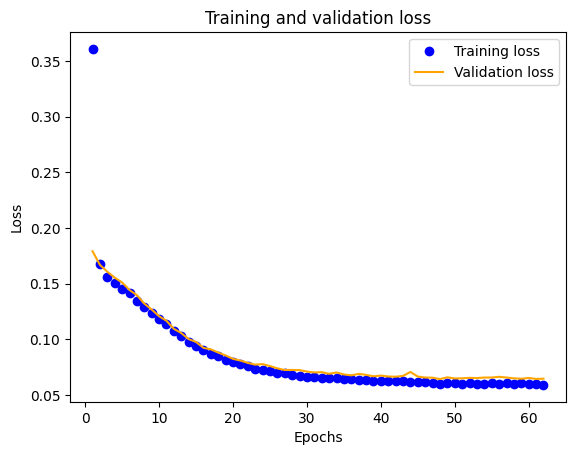

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{results_dir}/loss.png')

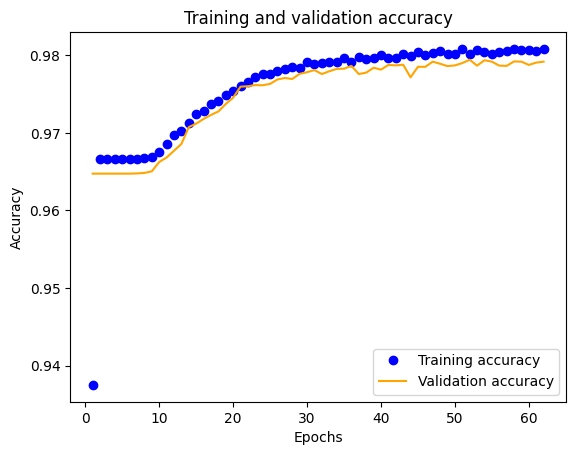

In [10]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig(f'{results_dir}/accuracy.png')
plt.show()

In [11]:
preds = model.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)

5301/5301 [==============================] - 5s 906us/step


In [12]:
predictionsFiles

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
pd.DataFrame(predictionsFiles).to_csv(f"{results_dir}/predictionsFiles.csv",header='predict', index=False)

In [14]:
pd.DataFrame(y_test).to_csv(f"{results_dir}/true.csv",header='true', index=False)

In [15]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3434567451477051
Test accuracy: 0.8736720085144043


Confusion matrix:
[[129684   1315    938]
 [  8523  10364     37]
 [ 10610      4   8139]]


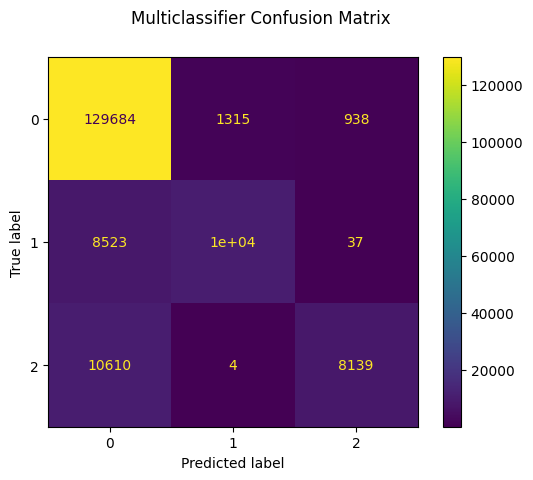

In [17]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig(f'{results_dir}/confusionMatrix.png')
plt.show()

In [18]:
model.save(f'{results_dir}/qkeras_model.h5')

/asic/projects/C/CMS_PIX_28/testing/tools/venvs/p3.11.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
import hls4ml
from fxpmath import Fxp
import os
import csv
def input_to_pixelout(x):
    N_INFERENCES = x.shape[0]

    # first create compout
    encoder_values_Ninferences = []
    for i in range(N_INFERENCES):
        encoder_values = []
        for j in range(16):
            a = x[i][j]
            encoder_sum = []
            if(a==0):
                encoder_sum = [0 for _ in range(16)]
                encoder_sum.reverse()
                
            elif(a==1):
                encoder_sum = [1]+[0 for _ in range(15)]
                encoder_sum.reverse()

            elif(a==2):
                encoder_sum = [2]+[0 for _ in range(15)]
                encoder_sum.reverse()

            elif(a==3):
                encoder_sum = [3]+[0 for _ in range(15)]
                encoder_sum.reverse()

            else:
                l3=[]
                if a%3 == 0:
                    result = int(a/3)
                    l3 = [3 for _ in range(result)]
                    l_diff = 16-len(l3)
                    encoder_sum = l3 + [0 for _ in range(l_diff)]
                    encoder_sum.reverse()
                else:
                    result = int(a//3)
                    l3 = [3 for _ in range(result)]
                    diff = a-sum(l3)
                    l3.append(diff)
                    l_diff = 16-len(l3)
                    encoder_sum = l3 + [0 for _ in range(l_diff)]
                    encoder_sum.reverse()

            encoder_values.append(encoder_sum)
        encoder_values = [j for i in encoder_values for j in i]
        encoder_values_Ninferences.append(encoder_values)
        
    compout_values_Ninferences = []
    for i in range(N_INFERENCES):
        compout_values = []
        for j in range(256):
            a = encoder_values_Ninferences[i][j]
            if(a==3):
                compout_values.append(7)
            elif(a==2):
                compout_values.append(3)
            elif(a==1):
                compout_values.append(1)
            else:
                compout_values.append(0)
        compout_values_Ninferences.append(compout_values)

    return compout_values_Ninferences

# convert code from hsl4ml style output to chip style input
def prepareWeights(path):
    data_fxp = Fxp(None, signed=True, n_word=4, n_int=0)
    data_fxp.rounding = 'around'
    def to_fxp(val):
        return data_fxp(val)

    b5_data = pd.read_csv(os.path.join(path, 'b5.txt'), header=None)
    w5_data = pd.read_csv(os.path.join(path, 'w5.txt'), header=None)
    b2_data = pd.read_csv(os.path.join(path, 'b2.txt'), header=None)
    w2_data = pd.read_csv(os.path.join(path, 'w2.txt'), header=None)
    # print(b5_data)

    b5_data_list = []
    w5_data_list = []
    b2_data_list = []
    w2_data_list = []

    for i in range(2, -1, -1):
        b5_data_list.append(to_fxp(b5_data.values[0][i]).bin())

    for i in range(173, -1, -1):
        w5_data_list.append(to_fxp(w5_data.values[0][i]).bin())

    for i in range(57, -1, -1):
        b2_data_list.append(to_fxp(b2_data.values[0][i]).bin())

    for i in range(927, -1, -1):
        w2_data_list.append(to_fxp(w2_data.values[0][i]).bin())

    b5_bin_list = [int(bin_string) for data in b5_data_list for bin_string in data]
    w5_bin_list = [int(bin_string) for data in w5_data_list for bin_string in data]
    b2_bin_list = [int(bin_string) for data in b2_data_list for bin_string in data]
    w2_bin_list = [int(bin_string) for data in w2_data_list for bin_string in data]
    pixel_list = [0 for _ in range(512)]
    b5_w5_b2_w2_pixel_list = b5_bin_list + w5_bin_list + b2_bin_list + w2_bin_list + pixel_list

    csv_file = os.path.join(path, 'b5_w5_b2_w2_pixel_bin.csv')
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(b5_w5_b2_w2_pixel_list)
    
    return csv_file

def prepare_weights_asic(model, x):        

        # write the current weights to file
        config = hls4ml.utils.config_from_keras_model(model, granularity='name')
        # Convert to an hls model
        hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, output_dir='./')
        hls_model.write()
        dnn_csv = prepareWeights("./firmware/weights/")
        
        # generate input csv
        pixelout = input_to_pixelout(x) #.numpy())
        pixel_compout_csv = './compouts.csv'
        with open(pixel_compout_csv, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(pixelout)

        return dnn_csv, pixel_compout_csv

In [21]:
dnn_csv, pixel_compout_csv = prepare_weights_asic(model, X_test)

Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 16]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 16]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], ou